<a href="https://colab.research.google.com/github/ruairi-mcc/Programming-for-big-data-/blob/main/Programming_for_big_data_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and Importing all of the necessary packages

In [2]:
!pip install windrose

In [3]:
!pip install cartopy

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

from mpl_toolkits.axes_grid.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import windrose

Issue with shapely package whic affects plotting. Uninstall and reinstall of 

In [5]:
!pip uninstall shapely
!pip install shapely --no-binary shapely

Found existing installation: Shapely 1.8.2
Uninstalling Shapely-1.8.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Shapely-1.8.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/shapely/*
Proceed (y/n)? y
  Successfully uninstalled Shapely-1.8.2
  Using cached Shapely-1.8.2.tar.gz (198 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.2-cp37-cp37m-linux_x86_64.whl size=665712 sha256=9a1fdce13390901b65f1116423f8a6afd5634654547c7f940bed8793ff7a8158
  Stored in directory: /root/.cache/pip/wheels/2f/9e/07/e9e90942b4e31275785d2f7e455607bfe876e53906307f80cd
Successfully built shapely
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is i

#Configuring the Spark session

In [6]:
#Run Once
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://www-us.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz

# check if the file is unziped 
!ls

!pip install -q findspark
#Run Once
import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

drive	     spark-3.0.2-bin-hadoop2.7	    spark-3.0.2-bin-hadoop2.7.tgz.1
sample_data  spark-3.0.2-bin-hadoop2.7.tgz


In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark

#Mounting Google drive to access the saved datasets

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Reading the dataset into a Spark DataFrame


In [9]:
turbine = spark.read.csv('/content/drive/MyDrive/T1.csv', header=True, inferSchema=True)
type(turbine)

pyspark.sql.dataframe.DataFrame

#Converting the data into an RDD. Not required or used for this project. 

In [10]:
turbine_rdd = turbine.rdd
type(turbine_rdd)

pyspark.rdd.RDD

#Caching the dataset and examining the contents

In [11]:
turbine.cache()

turbine = turbine.toDF(*[c.lower() for c in turbine.columns])


print(turbine.show(5))
print()
print(turbine.printSchema())
print()
print(turbine.count())

+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None

root
 |-- date/time: str

# Creating hour and month variables from the "date/time" column

In [12]:
from pyspark.sql.functions import substring
turbine = turbine.withColumn("month", substring("date/time", 4,2))
turbine = turbine.withColumn("hour", substring("date/time", 12,2))

from pyspark.sql.types import IntegerType
turbine = turbine.withColumn('month', turbine.month.cast(IntegerType()))
turbine = turbine.withColumn('hour', turbine.hour.cast(IntegerType()))

print(turbine.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0|
+----------------+-------------------+----------------+-----------------

In [13]:
pd.options.display.float_format = '{:.2f}'.format
turbine.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
count,50530.00,50530.00,50530.00
mean,7.56,1492.18,1307.68
std,4.23,1368.02,1312.46
min,0.00,0.00,-2.47
25%,4.20,161.33,50.68
50%,7.10,1063.78,825.84
75%,10.30,2964.97,2482.51
max,25.21,3600.00,3618.73


#Sampling the data to create some plotss. 

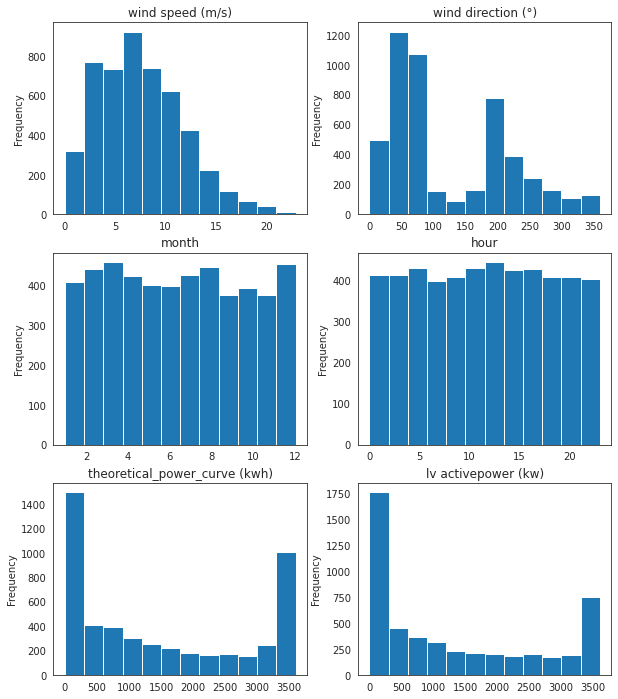

In [14]:
sample_df = turbine.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

columns = ['wind speed (m/s)', 'wind direction (°)', 'month', 'hour', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(10,12))
for each in columns:
    plt.subplot(3,2,i)
    sample_df[each].plot.hist(bins=12)
    plt.title(each)
    i += 1

# Average power production by month


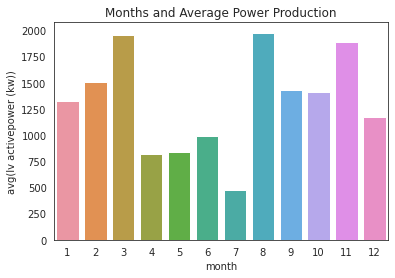

In [15]:
monthly = turbine.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

# Average power production by hour


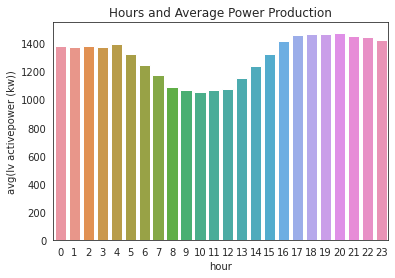

In [16]:
hourly = turbine.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='hour', y='avg(lv activepower (kw))', data=hourly)
plt.title('Hours and Average Power Production');

,wind speed (m/s),wind direction (°),month,hour,theoretical_power_curve (kwh),lv activepower (kw)
wind speed (m/s),1.00,-0.08,-0.01,0.03,0.95,0.91
wind direction (°),-0.08,1.00,-0.18,0.00,-0.11,-0.06
month,-0.01,-0.18,1.00,-0.01,-0.00,0.04
hour,0.03,0.00,-0.01,1.00,0.03,0.03
theoretical_power_curve (kwh),0.95,-0.11,-0.00,0.03,1.00,0.94
lv activepower (kw),0.91,-0.06,0.04,0.03,0.94,1.00


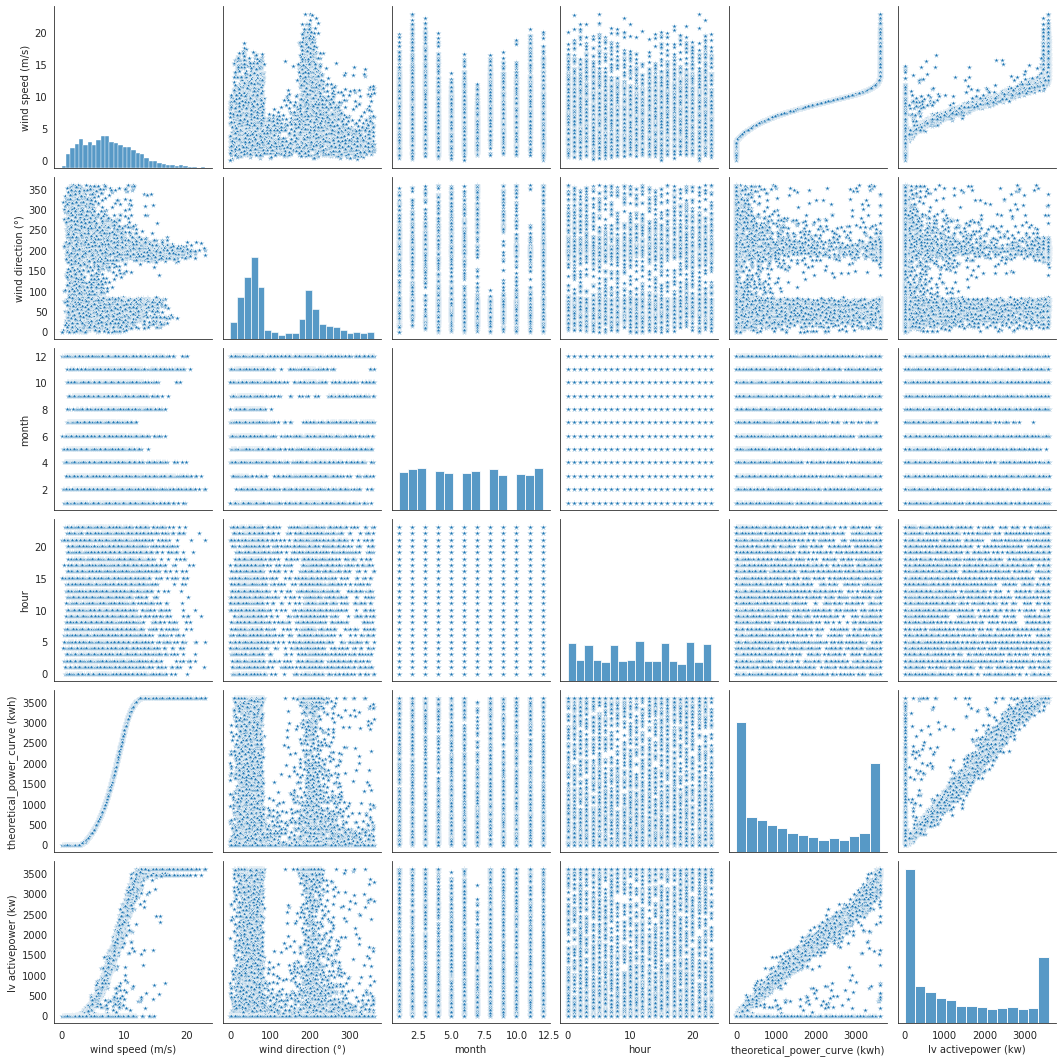

In [17]:
display(sample_df[columns].corr())
sns.pairplot(sample_df[columns], markers='*');

# Using Filter and aggregate functions to show the average power production in increments of 5 m/s wind speed


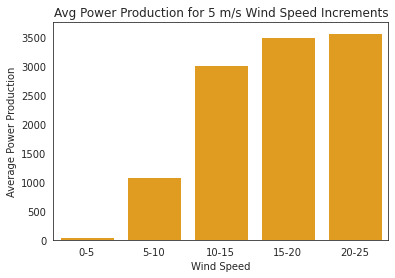

In [18]:
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = turbine.filter((turbine['wind speed (m/s)'] > i) 
                                & (turbine['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0] 
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))

sns.barplot(x=wind_speed, y=avg_power, color='orange')
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');

#Plotting the power curve based on the SCADA data 

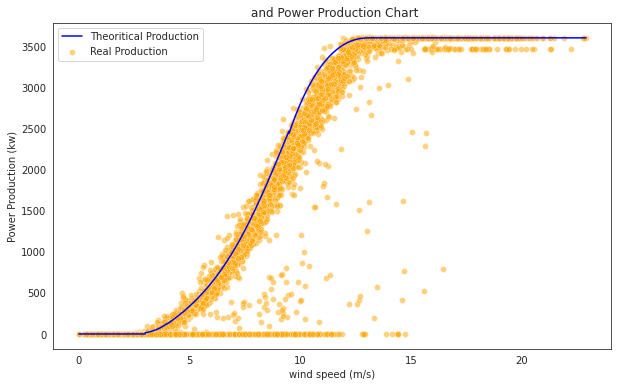

In [19]:
plt.figure(figsize=(10,6))

sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=sample_df)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=sample_df)

plt.title(' and Power Production Chart')
plt.ylabel('Power Production (kw)');

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
699,2.94,0.00,0.00
2364,1.80,0.00,0.00
5760,2.01,0.00,0.00
2614,1.22,0.00,0.00
5284,1.39,0.00,0.00


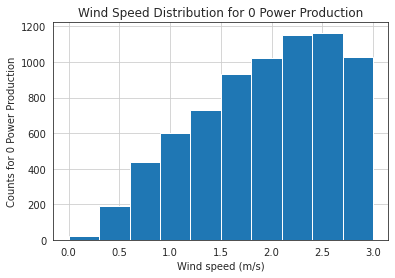

In [20]:
# Filter the big data where the real and theoritical power productions are equal to 0
zero_theo_power = turbine.filter((turbine['lv activepower (kw)'] == 0)
                                  & (turbine['theoretical_power_curve (kwh)'] == 0)).toPandas()

display(zero_theo_power[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

# Let's see the wind speed distribution for 0 power production
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

In [21]:
# Observations for the wind speed > 3m/s and power production = 0, 
# While theoritically there should be power production
zero_power = turbine.filter((turbine['lv activepower (kw)'] == 0)
                            & (turbine['theoretical_power_curve (kwh)'] != 0)
                            & (turbine['wind speed (m/s)'] > 3)).toPandas()
display(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour
0,03 01 2018 15:40,0.00,3.74,83.99,245.07,1,15
1,03 01 2018 16:40,0.00,3.03,17.18,221.09,1,16
2,03 01 2018 16:50,0.00,3.20,25.43,232.68,1,16
3,03 01 2018 17:00,0.00,3.91,110.98,241.97,1,17
4,04 01 2018 13:50,0.00,3.44,45.74,79.09,1,13


No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497


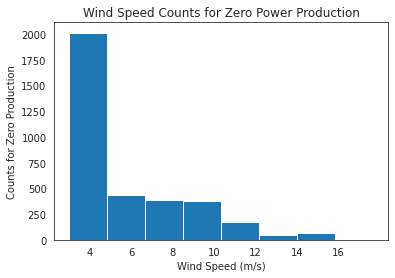

In [22]:
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

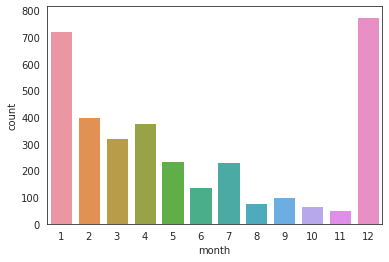

In [23]:
sns.countplot(zero_power['month']);

In [24]:
# Excluding the observations meeting the filter criterias 
turbine = turbine.filter(~((turbine['lv activepower (kw)'] == 0)
                            & (turbine['theoretical_power_curve (kwh)'] != 0)
                            & (turbine['wind speed (m/s)'] > 3)))

In [25]:
# Create a pandas df for visualization
wind_speed = turbine.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.45584678649902   Quantile (0.75):  10.4771900177001
Lower threshold:  -4.576168060302599  Upper threshold:  19.50920486450172


In [26]:
# Fancy indexing for outliers
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(wind_speed['wind speed (m/s)'][outlier_tf].sample(10))

Total Number of Outliers:  407
------------------------------
Some Examples of Outliers:
10895   21.33
10880   19.60
2525    20.04
8901    20.48
3554    22.81
3406    19.72
3241    20.30
3505    21.88
46360   20.57
8944    19.51
Name: wind speed (m/s), dtype: float64


In [27]:
turbine.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(turbine['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427974706|
+------------------------+



In [28]:
from pyspark.sql import functions as F
turbine = turbine.withColumn('wind speed (m/s)', 
                               F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               .otherwise(F.col('wind speed (m/s)')))
turbine.count()

47033

In [29]:
# High level power production
turbine.filter(((turbine['month'] == 3) | (turbine['month'] == 8) | (turbine['month'] == 11)) 
                & ((turbine['hour'] >= 16) | (turbine['hour'] <= 24)) 
                & ((turbine['wind direction (°)'] > 0) | (turbine['wind direction (°)'] < 90))
                & ((turbine['wind direction (°)'] > 180) | (turbine['wind direction (°)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      2013.4446757880403|
+------------------------+



In [30]:
# Low level power production
turbine.filter((turbine['month'] == 7) 
                & ((turbine['hour'] >= 9) | (turbine['hour'] <= 11)) 
                & ((turbine['wind direction (°)'] > 90) | (turbine['wind direction (°)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|       503.1644205414878|
+------------------------+



In [31]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
turbine = turbine.withColumn('label', turbine['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(turbine)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



#Splitting the train and test data

In [32]:
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  37421
Test dataset :  9612


#Creating the model 
#Training the model
#Testing the model 


In [33]:
from pyspark.ml.regression import GBTRegressor

# Creating the gbm regressor object
gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Training the model with train data
gbm_model = gbm.fit(train_df)

# Predicting using the test data
y_pred = gbm_model.transform(test_df)

# Initial look at the target and predicted values
y_pred.select('label', 'prediction').show(20)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0|24.654382250959728|
|             0.0|22.559738250840034|
| 346.68569946289| 310.2986231771745|
|296.469909667968| 292.6397742690547|
|380.650695800781| 418.9054305237339|
| 453.76919555664| 524.1387444642248|
|837.063720703125| 733.2814797473976|
|874.722473144531|1044.0674319540108|
|842.209289550781|1044.0674319540108|
|1182.03503417968| 1173.769625105424|
|1999.54602050781|1788.9760655944817|
|802.475280761718| 1085.254949977278|
|1009.81701660156|1291.9834383083846|
|2300.80395507812| 2173.009615163626|
|3083.24389648437| 3083.830174466819|
|3147.27587890625| 3083.830174466819|
|3374.42309570312|3446.5119543985115|
|      735.859375|3446.5119543985115|
|  3469.412109375|3446.5119543985115|
|3377.64990234375|3446.5119543985115|
+----------------+------------------+
only showing top 20 rows



#Model evaluation

In [34]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.9800299761461706
MAE      :  84.12263520703235
RMSE     :  184.29007768948927


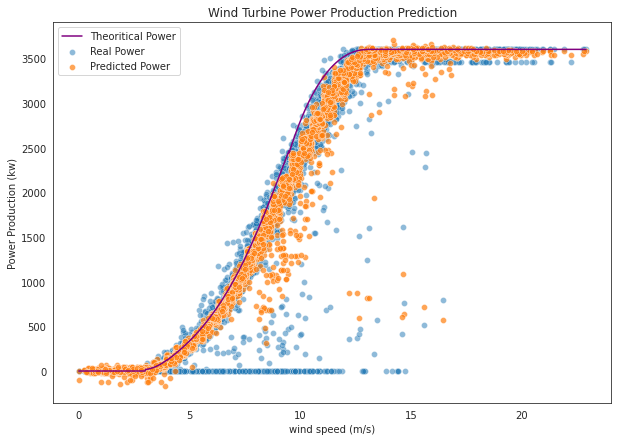

In [35]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();

#Loading the weather data into a Spark Dataframe

In [36]:
weather = spark.read.csv('/content/drive/MyDrive/30 year weather data combined.csv', header=True, inferSchema=True)
type(weather)

pyspark.sql.dataframe.DataFrame

In [37]:
weather_rdd = weather.rdd
type(weather_rdd)

pyspark.rdd.RDD

In [38]:
weather.cache()

print(weather.show(5))
print()
print(weather.printSchema())
print()
print(weather.count())

+---+-------------------+----+----+----+-----+-----+----+------+----+-----+----+---+---+-------+-----+-----+--------+------------------+------------------+--------+
|_c0|               date|rain|temp|wetb|dewpt|vappr|rhum|   msl|wdsp|wddir|  ww|  w|sun|    vis| clht|clamt|location|          latitude|         longitude|altitude|
+---+-------------------+----+----+----+-----+-----+----+------+----+-----+----+---+---+-------+-----+-----+--------+------------------+------------------+--------+
|  0|1939-10-01 01:00:00| 0.0| 6.0| 5.9|  6.1|  9.2|98.0|1007.3| 0.0|  0.0|10.0|2.0|0.0| 7000.0|200.0|  5.0|  foynes|52.608000000000004|-9.107999999999999|     4.0|
|  1|1939-10-01 02:00:00| 0.0| 6.0| 5.9|  6.1|  9.2|98.0|1007.1| 5.0| 20.0|10.0|2.0|0.0| 7000.0| 28.0|  7.0|  foynes|52.608000000000004|-9.107999999999999|     4.0|
|  2|1939-10-01 03:00:00| 0.0| 8.1| 7.4|  6.6|  9.7|90.0|1006.9| 5.0| 30.0|10.0|2.0|0.0|10000.0| 28.0|  7.0|  foynes|52.608000000000004|-9.107999999999999|     4.0|
|  3|1939-

# Dropping the unused columns

In [39]:
weather = weather.drop('rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt')
weather.show(5)

+---+-------------------+----+-----+--------+------------------+------------------+--------+
|_c0|               date|wdsp|wddir|location|          latitude|         longitude|altitude|
+---+-------------------+----+-----+--------+------------------+------------------+--------+
|  0|1939-10-01 01:00:00| 0.0|  0.0|  foynes|52.608000000000004|-9.107999999999999|     4.0|
|  1|1939-10-01 02:00:00| 5.0| 20.0|  foynes|52.608000000000004|-9.107999999999999|     4.0|
|  2|1939-10-01 03:00:00| 5.0| 30.0|  foynes|52.608000000000004|-9.107999999999999|     4.0|
|  3|1939-10-01 04:00:00| 5.0| 30.0|  foynes|52.608000000000004|-9.107999999999999|     4.0|
|  4|1939-10-01 05:00:00| 9.0| 30.0|  foynes|52.608000000000004|-9.107999999999999|     4.0|
+---+-------------------+----+-----+--------+------------------+------------------+--------+
only showing top 5 rows



#Converting the date column to datetime format

In [40]:
weather_2 = weather.toPandas()
weather_2['date'] = pd.to_datetime(weather_2['date'])
 
weather_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3442285 entries, 0 to 3442284
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   _c0        int32         
 1   date       datetime64[ns]
 2   wdsp       float64       
 3   wddir      float64       
 4   location   object        
 5   latitude   float64       
 6   longitude  float64       
 7   altitude   float64       
dtypes: datetime64[ns](1), float64(5), int32(1), object(1)
memory usage: 197.0+ MB


In [41]:
weather_2['hour'] = weather_2['date'].dt.hour
weather_2['day'] = weather_2['date'].dt.day
weather_2['month'] = weather_2['date'].dt.month
weather_2['year'] = weather_2['date'].dt.year

weather_2

,_c0,date,wdsp,wddir,location,latitude,longitude,altitude,hour,day,month,year
0,0,1939-10-01 01:00:00,0.00,0.00,foynes,52.61,-9.11,4.00,1,1,10,1939
1,1,1939-10-01 02:00:00,5.00,20.00,foynes,52.61,-9.11,4.00,2,1,10,1939
2,2,1939-10-01 03:00:00,5.00,30.00,foynes,52.61,-9.11,4.00,3,1,10,1939
3,3,1939-10-01 04:00:00,5.00,30.00,foynes,52.61,-9.11,4.00,4,1,10,1939
4,4,1939-10-01 05:00:00,9.00,30.00,foynes,52.61,-9.11,4.00,5,1,10,1939
...,...,...,...,...,...,...,...,...,...,...,...,...
3442280,265152,2022-04-01 00:00:00,17.00,20.00,malin head,55.37,-7.34,20.00,0,1,4,2022
3442281,265152,2022-04-01 00:00:00,12.00,330.00,cork,51.85,-8.49,155.00,0,1,4,2022
3442282,265152,2022-04-01 00:00:00,3.00,10.00,shannon,52.69,-8.92,15.00,0,1,4,2022
3442283,265152,2022-04-01 00:00:00,9.00,310.00,dublin,53.43,-6.24,71.00,0,1,4,2022


In [42]:
weather_2 = weather_2[weather_2.year > 1980]
weather_2

,_c0,date,wdsp,wddir,location,latitude,longitude,altitude,hour,day,month,year
783188,230135,1981-01-01 00:00:00,12.00,290.00,birr,53.09,-7.89,72.00,0,1,1,1981
783189,24143,1981-01-01 00:00:00,19.00,300.00,galway,53.28,-9.01,20.00,0,1,1,1981
783190,206759,1981-01-01 00:00:00,19.00,300.00,kilkenny,52.66,-7.27,65.00,0,1,1,1981
783191,262991,1981-01-01 00:00:00,17.00,300.00,clones,54.18,-7.23,89.00,0,1,1,1981
783192,24144,1981-01-01 01:00:00,16.00,300.00,galway,53.28,-9.01,20.00,1,1,1,1981
...,...,...,...,...,...,...,...,...,...,...,...,...
3442280,265152,2022-04-01 00:00:00,17.00,20.00,malin head,55.37,-7.34,20.00,0,1,4,2022
3442281,265152,2022-04-01 00:00:00,12.00,330.00,cork,51.85,-8.49,155.00,0,1,4,2022
3442282,265152,2022-04-01 00:00:00,3.00,10.00,shannon,52.69,-8.92,15.00,0,1,4,2022
3442283,265152,2022-04-01 00:00:00,9.00,310.00,dublin,53.43,-6.24,71.00,0,1,4,2022


In [43]:
weather_2.describe()

,_c0,wdsp,wddir,latitude,longitude,altitude,hour,day,month,year
count,2659097.00,2655827.00,2655582.00,2659097.00,2659097.00,2659097.00,2659097.00,2659097.00,2659097.00,2659097.00
mean,192094.90,9.82,199.45,53.27,-8.05,59.68,11.50,15.73,6.48,2002.69
std,126193.74,6.24,90.76,1.03,1.32,43.50,6.92,8.80,3.46,10.47
min,0.00,0.00,0.00,51.85,-10.24,9.00,0.00,1.00,1.00,1981.00
25%,86114.00,5.00,140.00,52.66,-8.92,20.00,5.00,8.00,3.00,1995.00
50%,179913.00,9.00,210.00,53.28,-7.89,65.00,11.00,16.00,6.00,2003.00
75%,262340.00,13.00,270.00,54.18,-7.23,89.00,17.00,23.00,9.00,2011.00
max,504486.00,99.00,990.00,55.37,-6.24,155.00,23.00,31.00,12.00,2022.00


In [44]:
weather_2.loc[weather_2['wddir'] == 990]


,_c0,date,wdsp,wddir,location,latitude,longitude,altitude,hour,day,month,year
1763150,388594,1999-01-29 19:00:00,NaN,990.00,birr,53.09,-7.89,72.00,19,29,1,1999
1763161,388595,1999-01-29 20:00:00,99.00,990.00,birr,53.09,-7.89,72.00,20,29,1,1999


In [45]:
weather_2 = weather_2[weather_2.wddir != 990]
weather_2.describe()

,_c0,wdsp,wddir,latitude,longitude,altitude,hour,day,month,year
count,2659095.00,2655826.00,2655580.00,2659095.00,2659095.00,2659095.00,2659095.00,2659095.00,2659095.00,2659095.00
mean,192094.76,9.82,199.45,53.27,-8.05,59.68,11.50,15.73,6.48,2002.69
std,126193.67,6.24,90.76,1.03,1.32,43.50,6.92,8.80,3.46,10.47
min,0.00,0.00,0.00,51.85,-10.24,9.00,0.00,1.00,1.00,1981.00
25%,86114.00,5.00,140.00,52.66,-8.92,20.00,5.00,8.00,3.00,1995.00
50%,179913.00,9.00,210.00,53.28,-7.89,65.00,11.00,16.00,6.00,2003.00
75%,262340.00,13.00,270.00,54.18,-7.23,89.00,17.00,23.00,9.00,2011.00
max,504486.00,61.00,360.00,55.37,-6.24,155.00,23.00,31.00,12.00,2022.00


In [46]:
weather_2.loc[weather_2['wddir'] == 0]


,_c0,date,wdsp,wddir,location,latitude,longitude,altitude,hour,day,month,year
783565,206853,1981-01-04 22:00:00,0.00,0.00,kilkenny,52.66,-7.27,65.00,22,4,1,1981
783569,24238,1981-01-04 23:00:00,0.00,0.00,galway,53.28,-9.01,20.00,23,4,1,1981
783574,24239,1981-01-05 00:00:00,0.00,0.00,galway,53.28,-9.01,20.00,0,5,1,1981
783575,206855,1981-01-05 00:00:00,0.00,0.00,kilkenny,52.66,-7.27,65.00,0,5,1,1981
783579,24240,1981-01-05 01:00:00,0.00,0.00,galway,53.28,-9.01,20.00,1,5,1,1981
...,...,...,...,...,...,...,...,...,...,...,...,...
3328918,248957,2020-05-26 05:00:00,0.00,0.00,cork,51.85,-8.49,155.00,5,26,5,2020
3329052,248976,2020-05-27 00:00:00,0.00,0.00,cork,51.85,-8.49,155.00,0,27,5,2020
3342359,250877,2020-08-14 05:00:00,0.00,0.00,cork,51.85,-8.49,155.00,5,14,8,2020
3342838,250946,2020-08-17 02:00:00,0.00,0.00,cork,51.85,-8.49,155.00,2,17,8,2020


In [47]:
weather_2.year.unique()

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [48]:
weather_2

,_c0,date,wdsp,wddir,location,latitude,longitude,altitude,hour,day,month,year
783188,230135,1981-01-01 00:00:00,12.00,290.00,birr,53.09,-7.89,72.00,0,1,1,1981
783189,24143,1981-01-01 00:00:00,19.00,300.00,galway,53.28,-9.01,20.00,0,1,1,1981
783190,206759,1981-01-01 00:00:00,19.00,300.00,kilkenny,52.66,-7.27,65.00,0,1,1,1981
783191,262991,1981-01-01 00:00:00,17.00,300.00,clones,54.18,-7.23,89.00,0,1,1,1981
783192,24144,1981-01-01 01:00:00,16.00,300.00,galway,53.28,-9.01,20.00,1,1,1,1981
...,...,...,...,...,...,...,...,...,...,...,...,...
3442280,265152,2022-04-01 00:00:00,17.00,20.00,malin head,55.37,-7.34,20.00,0,1,4,2022
3442281,265152,2022-04-01 00:00:00,12.00,330.00,cork,51.85,-8.49,155.00,0,1,4,2022
3442282,265152,2022-04-01 00:00:00,3.00,10.00,shannon,52.69,-8.92,15.00,0,1,4,2022
3442283,265152,2022-04-01 00:00:00,9.00,310.00,dublin,53.43,-6.24,71.00,0,1,4,2022


In [98]:
weather_2[weather_2.isnull().any(axis=1)]


,_c0,date,wdsp,wddir,location,latitude,longitude,altitude,hour,day,month,year
1133037,356231,1991-08-22 00:00:00,9.00,NaN,clones,54.18,-7.23,89.00,0,22,8,1991
1133042,356232,1991-08-22 01:00:00,9.00,NaN,clones,54.18,-7.23,89.00,1,22,8,1991
1133044,356233,1991-08-22 02:00:00,7.00,NaN,clones,54.18,-7.23,89.00,2,22,8,1991
1133047,356234,1991-08-22 03:00:00,7.00,NaN,clones,54.18,-7.23,89.00,3,22,8,1991
1133050,356235,1991-08-22 04:00:00,9.00,NaN,clones,54.18,-7.23,89.00,4,22,8,1991
...,...,...,...,...,...,...,...,...,...,...,...,...
3328449,248890,2020-05-23 10:00:00,NaN,NaN,casement,53.31,-6.44,91.00,10,23,5,2020
3328452,248891,2020-05-23 11:00:00,NaN,NaN,casement,53.31,-6.44,91.00,11,23,5,2020
3328461,248892,2020-05-23 12:00:00,NaN,NaN,casement,53.31,-6.44,91.00,12,23,5,2020
3361281,253581,2020-12-04 21:00:00,43.00,NaN,malin head,55.37,-7.34,20.00,21,4,12,2020


In [100]:
weather_2 = weather_2.dropna()


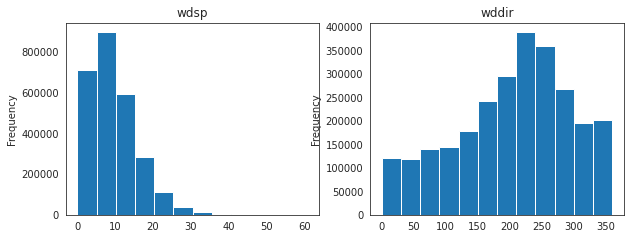

In [101]:
columns = ['wdsp', 'wddir']
i=1
plt.figure(figsize=(10,12))
for each in columns:
    plt.subplot(3,2,i)
    weather_2[each].plot.hist(bins=12)
    plt.title(each)
    i += 1

#Creating a windrose diagram for Ireland 

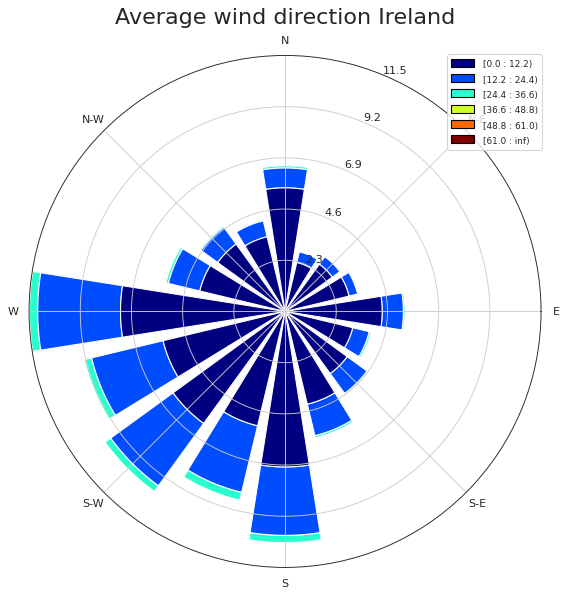

In [102]:
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(weather_2.wddir,
       weather_2.wdsp,
       normed=True, #get % of number of hours
       opening= 0.8, #width of bars
       edgecolor= 'white')

ax.set_legend(loc = "best")
plt.title(f"Average wind direction Ireland", fontsize = 20)
plt.show()

In [103]:
x = weather_2['month']
y = weather_2["wdsp"]

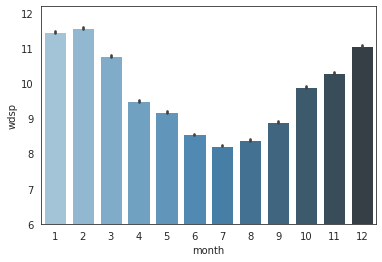

In [104]:
sns.barplot(x,y,data = weather_2, palette="Blues_d")
plt.ylim(6)
plt.show()

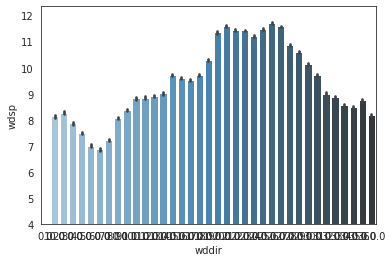

In [105]:
x2 = weather_2['wddir']

sns.barplot(x2,y,data = weather_2, palette="Blues_d")
plt.ylim(4)
plt.show()

#Plotting the windmap for various locations around ireland


In [106]:
birr_lon, birr_lat = (-7.89, 53.09)
birr_wdsp = weather_2.loc[weather_2['location'] == 'birr', "wdsp"]
birr_wddir = weather_2.loc[weather_2['location'] == 'birr', "wddir"]

galway_lon, galway_lat = (-9.01, 53.28)
galway_wdsp = weather_2.loc[weather_2['location'] == 'galway', "wdsp"]
galway_wddir = weather_2.loc[weather_2['location'] == 'galway', "wddir"]

kilkenny_lon, kilkenny_lat = (-7.27, 52.66)
kilkenny_wdsp = weather_2.loc[weather_2['location'] == 'kilkenny', "wdsp"]
kilkenny_wddir = weather_2.loc[weather_2['location'] == 'kilkenny', "wddir"]

clones_lon, clones_lat = (-7.23, 54.18)
clones_wdsp = weather_2.loc[weather_2['location'] == 'clones', "wdsp"]
clones_wddir = weather_2.loc[weather_2['location'] == 'clones', "wddir"]

cork_lon, cork_lat = (-8.49, 51.85)
cork_wdsp = weather_2.loc[weather_2['location'] == 'cork', "wdsp"]
cork_wddir = weather_2.loc[weather_2['location'] == 'cork', "wddir"]

valentia_lon, valentia_lat = (-10.24, 51.94)
valentia_wdsp = weather_2.loc[weather_2['location'] == 'valentia', "wdsp"]
valentia_wddir = weather_2.loc[weather_2['location'] == 'valentia', "wddir"]

malin_lon, malin_lat = (-7.34, 55.37)
malin_wdsp = weather_2.loc[weather_2['location'] == 'malin head', "wdsp"]
malin_wddir = weather_2.loc[weather_2['location'] == 'malin head', "wddir"]

dublin_lon, dublin_lat = (-6.24, 53.43)
dublin_wdsp = weather_2.loc[weather_2['location'] == 'dublin', "wdsp"]
dublin_wddir = weather_2.loc[weather_2['location'] == 'dublin', "wddir"]

belmullet_lon, belmullet_lat = (-10.01, 54.23) 
belmullet_wdsp = weather_2.loc[weather_2['location'] == 'belmullet', "wdsp"]
belmullet_wddir = weather_2.loc[weather_2['location'] == 'belmullet', "wddir"]

casement_lon, casement_lat = (-6.44, 53.31)
casement_wdsp = weather_2.loc[weather_2['location'] == 'casement', "wdsp"]
casement_wddir = weather_2.loc[weather_2['location'] == 'casement', "wddir"]

shannon_lon, shannon_lat = (-8.92, 52.69)
shannon_wdsp = weather_2.loc[weather_2['location'] == 'shannon', "wdsp"]
shannon_wddir = weather_2.loc[weather_2['location'] == 'shannon', "wddir"]

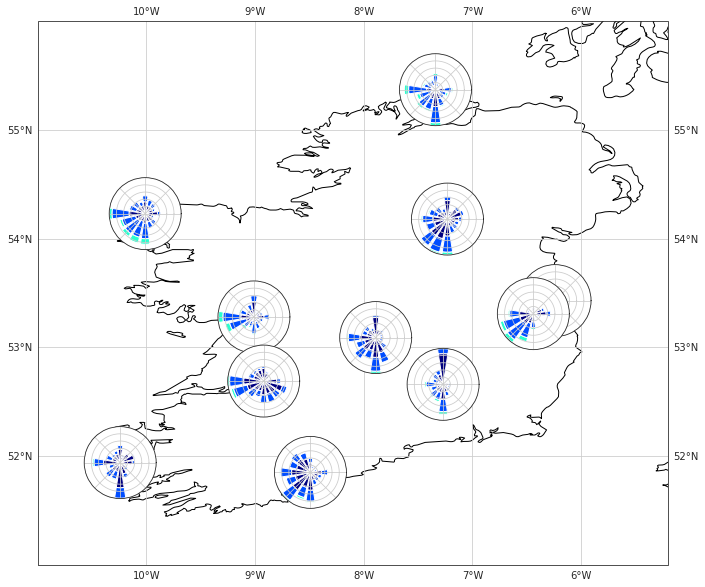

In [110]:
minlon, maxlon, minlat, maxlat = (-11, -5.2, 51, 56)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(15, 10))

# Draw main ax on top of which we will add windroses
main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.gridlines(draw_labels=True)
main_ax.coastlines()
#request = cimgt.OSM()
#main_ax.add_image(request, 12)

# Inset axe it with a fixed size
wrax_birr = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(birr_lon, birr_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)
wrax_galway = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(galway_lon, galway_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)
wrax_kilkenny = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(kilkenny_lon, kilkenny_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)
wrax_clones = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(clones_lon, clones_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)
wrax_cork = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(cork_lon, cork_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)
wrax_valentia = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(valentia_lon, valentia_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)
wrax_malin = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(malin_lon, malin_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)
wrax_dublin = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(dublin_lon, dublin_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)
wrax_belmullet = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(belmullet_lon, belmullet_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)

wrax_casement = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(casement_lon, casement_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)
wrax_shannon = inset_axes(main_ax,
                       width=1, # size in inches
                       height=1, # size in inches
                       loc='center', # center bbox at given position
                       bbox_to_anchor=(shannon_lon, shannon_lat), # position of the axe
                       bbox_transform=main_ax.transData, # use data coordinate (not axe→coordinate)
                       axes_class=windrose.WindroseAxes, # specify the class of the axe
)


wrax_birr.bar(birr_wddir, birr_wdsp)
wrax_galway.bar(galway_wddir, galway_wdsp)
wrax_kilkenny.bar(kilkenny_wddir, kilkenny_wdsp)
wrax_clones.bar(clones_wddir, clones_wdsp)
wrax_cork.bar(cork_wddir, cork_wdsp)
wrax_valentia.bar(valentia_wddir, valentia_wdsp)
wrax_malin.bar(malin_wddir, malin_wdsp)
wrax_dublin.bar(dublin_wddir, dublin_wdsp)
wrax_belmullet.bar(belmullet_wddir, belmullet_wdsp)
wrax_casement.bar(casement_wddir, casement_wdsp)
wrax_shannon.bar(shannon_wddir, shannon_wdsp)

for ax in [wrax_birr, wrax_galway, wrax_kilkenny, wrax_clones, wrax_cork, wrax_valentia, wrax_malin, wrax_dublin, wrax_belmullet, wrax_casement, wrax_shannon]:
  ax.tick_params(labelleft=False, labelbottom=False)